# Комбинация модели Random Forest и байесовских методов
Импорт необходимых библиотек

In [2]:
import numpy as np
import pandas as pd
import ast
import pywt
from scipy.stats import norm
from scipy.signal import welch, spectrogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, roc_auc_score, 
                            confusion_matrix, roc_curve, precision_recall_curve,
                            average_precision_score)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.base import BaseEstimator, TransformerMixin
warnings.filterwarnings("ignore")

# 1: Загрузка и подготовка данных

In [4]:
print("Загрузка данных...")
df = pd.read_csv('final_classification_dataset.csv')

def safe_convert(signal):
    """Безопасное преобразование сигнала в numpy array"""
    try:
        if isinstance(signal, str):
            arr = np.array(ast.literal_eval(signal))
        elif isinstance(signal, np.ndarray):
            arr = signal
        else:
            arr = np.zeros(100)
        
        # Стандартизация длины
        if len(arr) < 100:
            arr = np.pad(arr, (0, 100 - len(arr)), 'constant')
        return arr[:100]
    except:
        return np.zeros(100)

# Преобразование сигналов
df['clean_signal'] = df['clean_signal'].apply(safe_convert)
df['noise_signal'] = df['noise_signal'].apply(safe_convert)
print("Данные успешно загружены и преобразованы")

Загрузка данных...
Данные успешно загружены и преобразованы


# 2: Байесовский детектор сигналов

In [6]:
class BayesianSignalDetector:
    """Класс для байесовского обнаружения сигналов"""
    def __init__(self, noise_std=1.0, signal_std=0.5, prior_signal=0.5):
        self.noise_std = noise_std
        self.signal_std = signal_std
        self.prior_signal = prior_signal
        self.prior_noise = 1 - prior_signal
        
    def calculate_likelihood(self, x, hypothesis):
        """Вычисление правдоподобия"""
        if hypothesis == 'signal':
            return norm.pdf(x, 0, self.signal_std)
        else:  # noise
            return norm.pdf(x, 0, self.noise_std)
    
    def detect_signal(self, observations):
        """Обнаружение сигнала с вычислением апостериорных вероятностей"""
        posteriors = []
        for x in observations:
            l_signal = self.calculate_likelihood(x, 'signal')
            l_noise = self.calculate_likelihood(x, 'noise')
            
            p_signal = l_signal * self.prior_signal
            p_noise = l_noise * self.prior_noise
            
            total = p_signal + p_noise
            posteriors.append((p_signal/total, p_noise/total))
        
        return np.array(posteriors)

class AdaptiveBayesianFeatures(BaseEstimator, TransformerMixin):
    """Адаптивный извлекатель байесовских признаков"""
    def __init__(self, n_detectors=3):
        self.n_detectors = n_detectors
        self.detectors_ = []
        
    def fit(self, X, y=None):
        if y is None:
            raise ValueError("Требуется y для обучения")
            
        noise_signals = X.loc[y==0, 'noise_signal'] if 'noise_signal' in X.columns else X.iloc[:, 0]
        signal_signals = X.loc[y==1, 'noise_signal'] if 'noise_signal' in X.columns else X.iloc[:, 0]
        
        noise_params = self._estimate_parameters(noise_signals)
        signal_params = self._estimate_parameters(signal_signals)
        
        self.detectors_ = []
        for i in range(self.n_detectors):
            noise_std = noise_params[0] * (0.8 + i*0.2)
            signal_std = signal_params[1] * (0.7 + i*0.3)
            prior = 0.3 + i*0.2
            
            self.detectors_.append(
                BayesianSignalDetector(noise_std=noise_std, 
                                    signal_std=signal_std,
                                    prior_signal=prior)
            )
        return self
    
    def _estimate_parameters(self, signals):
        """Оценка параметров распределения"""
        if isinstance(signals, pd.Series):
            values = np.concatenate([s.flatten() for s in signals])
        else:
            values = signals.flatten()
            
        std = np.std(values)
        return (std, std*0.7)
    
    def transform(self, X):
        """Преобразование данных в байесовские признаки"""
        features = []
        for i, detector in enumerate(self.detectors_):
            signals = X['noise_signal'] if 'noise_signal' in X.columns else X.iloc[:, 0]
            
            detector_features = signals.apply(
                lambda x: self._extract_detector_features(x, detector, i))
            features.append(pd.DataFrame(detector_features.tolist()))
        
        return pd.concat(features, axis=1)
    
    def _extract_detector_features(self, signal, detector, detector_idx):
        """Извлечение признаков из детектора"""
        posteriors = detector.detect_signal(signal)
        return {
            f'bayes_{detector_idx}_p_signal_mean': np.mean(posteriors[:, 0]),
            f'bayes_{detector_idx}_p_signal_std': np.std(posteriors[:, 0]),
            f'bayes_{detector_idx}_p_signal_max': np.max(posteriors[:, 0]),
            f'bayes_{detector_idx}_p_signal_min': np.min(posteriors[:, 0]),
            f'bayes_{detector_idx}_snr_ratio': np.mean(posteriors[:, 0]) / (np.mean(posteriors[:, 1]) + 1e-10),
            f'bayes_{detector_idx}_signal_ratio': np.sum(posteriors[:, 0] > 0.5) / len(signal)
        }

# 3: Извлечение признаков

In [8]:
print("\nИзвлечение признаков...")

def extract_enhanced_features(signal, fs=1000):
    """Извлечение временных, частотных и вейвлет-признаков"""
    features = {}
    
    # 1. Статистические признаки
    features.update({
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'median': np.median(signal),
        'q25': np.percentile(signal, 25),
        'q75': np.percentile(signal, 75),
        'rms': np.sqrt(np.mean(signal**2)),
        'zero_crossings': ((signal[:-1] * signal[1:]) < 0).sum(),
        'entropy': np.sum(-signal * np.log(signal + 1e-10)),
        'skewness': pd.Series(signal).skew(),
        'kurtosis': pd.Series(signal).kurtosis()
    })
    
    # 2. Частотные признаки
    try:
        f, Pxx = welch(signal, fs=fs, nperseg=min(len(signal), 256))
        features.update({
            'spectral_centroid': np.sum(f * Pxx) / np.sum(Pxx),
            'spectral_bandwidth': np.sqrt(np.sum((f - features['spectral_centroid'])**2 * Pxx)),
            'spectral_entropy': -np.sum(Pxx * np.log2(Pxx + 1e-12)),
            'spectral_flatness': np.exp(np.mean(np.log(Pxx + 1e-10))) / np.mean(Pxx),
            'spectral_energy': np.sum(Pxx),
            'peak_frequency': f[np.argmax(Pxx)]
        })
    except:
        features.update({k: 0 for k in ['spectral_centroid', 'spectral_bandwidth', 
                                      'spectral_entropy', 'spectral_flatness',
                                      'spectral_energy', 'peak_frequency']})
    
    # 3. Вейвлет-признаки
    try:
        coeffs = pywt.wavedec(signal, 'db1', level=3)
        for i, c in enumerate(coeffs):
            features.update({
                f'wavelet_l{i}_mean': np.mean(c),
                f'wavelet_l{i}_std': np.std(c),
                f'wavelet_l{i}_energy': np.sum(c**2),
                f'wavelet_l{i}_entropy': -np.sum(c**2 * np.log(c**2 + 1e-10))
            })
        total_energy = np.sum([np.sum(c**2) for c in coeffs])
        features.update({
            'wavelet_total_energy': total_energy,
            'wavelet_energy_ratio': np.sum(coeffs[0]**2) / (total_energy + 1e-10)
        })
    except:
        wavelet_features = {f'wavelet_l{i}_{j}': 0 for i in range(4) 
                          for j in ['mean', 'std', 'energy', 'entropy']}
        wavelet_features.update({
            'wavelet_total_energy': 0,
            'wavelet_energy_ratio': 0
        })
        features.update(wavelet_features)
    
    return features

def extract_spectrogram_features(signal, fs=1000):
    """Извлечение признаков из спектрограммы"""
    features = {}
    
    try:
        f, t, Sxx = spectrogram(signal, fs=fs, nperseg=256)
        spectral_centroid = np.sum(f[:, None] * Sxx, axis=0) / np.sum(Sxx, axis=0)
        features.update({
            'spec_centroid_mean': np.mean(spectral_centroid),
            'spec_centroid_std': np.std(spectral_centroid),
            'spec_centroid_max': np.max(spectral_centroid),
            'spec_centroid_min': np.min(spectral_centroid),
            'spec_bandwidth_mean': np.mean(np.sqrt(np.sum((f[:, None] - spectral_centroid)**2 * Sxx, axis=0) / np.sum(Sxx, axis=0))),
            'spec_entropy_mean': np.mean(-np.sum(Sxx * np.log(Sxx + 1e-10), axis=0)),
            'spec_flatness_mean': np.mean(np.exp(np.mean(np.log(Sxx + 1e-10), axis=0)) / np.mean(Sxx, axis=0)),
            'spec_total_energy': np.sum(Sxx),
            'spec_peak_freq': f[np.argmax(np.mean(Sxx, axis=1))]
        })
    except:
        features.update({
            'spec_centroid_mean': 0, 'spec_centroid_std': 0,
            'spec_centroid_max': 0, 'spec_centroid_min': 0,
            'spec_bandwidth_mean': 0, 'spec_entropy_mean': 0,
            'spec_flatness_mean': 0, 'spec_total_energy': 0,
            'spec_peak_freq': 0
        })
    
    return features

# Извлечение стандартных признаков
clean_features = pd.DataFrame(df['clean_signal'].apply(
    lambda x: {**extract_enhanced_features(x), **extract_spectrogram_features(x)}
).tolist()).add_prefix('clean_')

noise_features = pd.DataFrame(df['noise_signal'].apply(
    lambda x: {**extract_enhanced_features(x), **extract_spectrogram_features(x)}
).tolist()).add_prefix('noise_')

# Подготовка данных для байесовских признаков
bayes_df = df[['noise_signal']].copy()
bayes_df['class'] = df['class']

# Извлечение байесовских признаков
print("Извлечение байесовских признаков...")
bayes_extractor = AdaptiveBayesianFeatures(n_detectors=3)
bayes_features = bayes_extractor.fit_transform(bayes_df.drop('class', axis=1), bayes_df['class'])

# Объединение всех признаков
X = pd.concat([clean_features, noise_features, bayes_features,
               df[['clean_signal_strength', 'noise_signal_strength']]], axis=1)
y = df['class']

# Обработка NaN/бесконечных значений
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
print("Извлечение признаков завершено")


Извлечение признаков...
Извлечение байесовских признаков...
Извлечение признаков завершено


# 4: Обучение модели

In [10]:
print("\nНастройка конвейера обучения...")

pipeline = make_imb_pipeline(
    RobustScaler(),
    SMOTE(random_state=42),
    SelectKBest(score_func=f_classif),
    RandomForestClassifier(random_state=42, class_weight='balanced')
)

param_grid = {
    'selectkbest__k': [30, 40, 50],
    'randomforestclassifier__n_estimators': [300, 400],
    'randomforestclassifier__max_depth': [None],
    'randomforestclassifier__min_samples_split': [2, 5],
    'randomforestclassifier__max_features': ['log2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nЗапуск GridSearchCV...")
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, 
                         scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
print("\nЛучшие параметры:", grid_search.best_params_)


Настройка конвейера обучения...

Запуск GridSearchCV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Лучшие параметры: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 400, 'selectkbest__k': 30}


# 5: Оценка модели


Оценка лучшей модели...

Отчет о классификации:
              precision    recall  f1-score   support

         Шум       0.90      0.97      0.93      1428
      Сигнал       0.97      0.89      0.93      1428

    accuracy                           0.93      2856
   macro avg       0.93      0.93      0.93      2856
weighted avg       0.93      0.93      0.93      2856



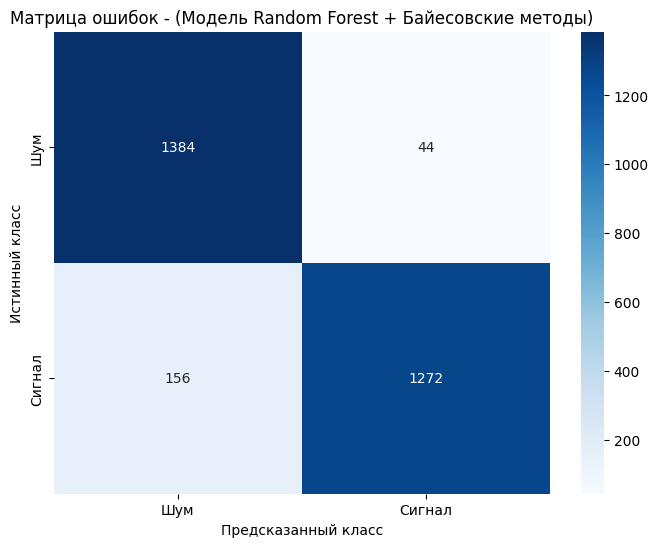

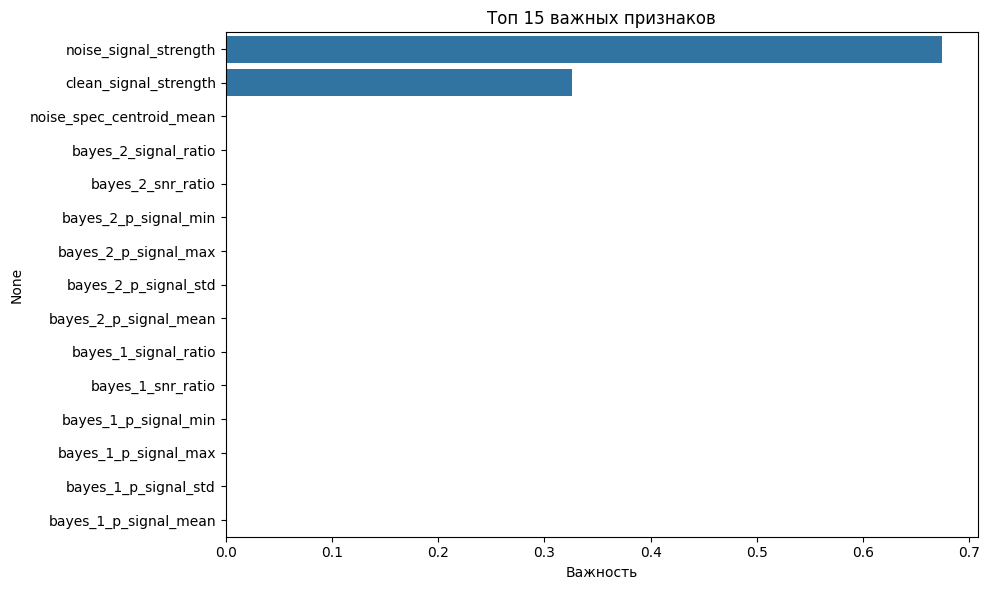

In [21]:
def evaluate_model(model, X, y):
    """Функция для оценки качества модели"""
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    print("\nОтчет о классификации:")
    print(classification_report(y, y_pred, target_names=['Шум', 'Сигнал']))
    
    # Матрица ошибок
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Шум', 'Сигнал'],
                yticklabels=['Шум', 'Сигнал'])
    plt.title('Матрица ошибок - (Модель Random Forest + Байесовские методы)')
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')
    plt.show()  
    
    # Важность признаков
    selected_features = X.columns[model.named_steps['selectkbest'].get_support()]
    importances = model.named_steps['randomforestclassifier'].feature_importances_
    top_features = pd.Series(importances, index=selected_features).sort_values(ascending=False)[:15]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_features.values, y=top_features.index)
    plt.title('Топ 15 важных признаков')
    plt.xlabel('Важность')
    plt.tight_layout()
    plt.show()
 
print("\nОценка лучшей модели...")
evaluate_model(best_model, X, y)